In [1]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm
IMG_SIZE = 224

%matplotlib inline

Using TensorFlow backend.


# Set random seed for reproducibility.

In [2]:


np.random.seed(2019)
tf.random.set_random_seed(2019)


# Loading & Exploration

In [3]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

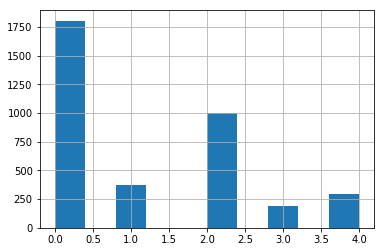

In [4]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

# Displaying some Sample Images

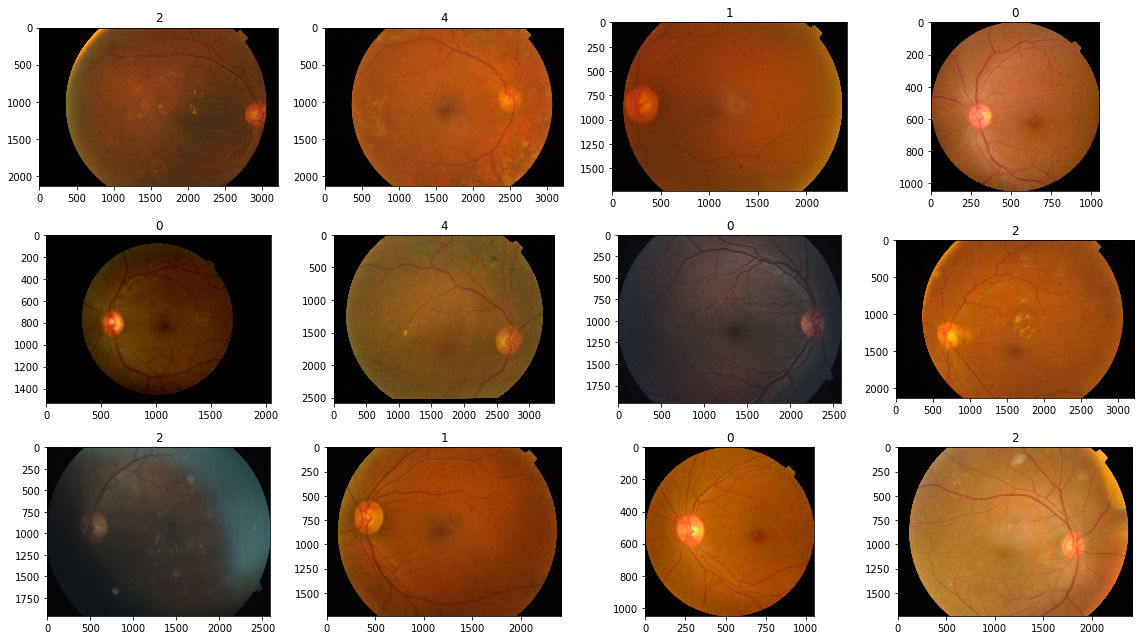

In [5]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(4*columns, 3*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Image Preprocessing using ben's idea


We will resize the images to 224x224, then create a single numpy array to hold the data.

In [6]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
    
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [7]:
def preprocess_image(image_path, desired_size=IMG_SIZE):
    im = load_ben_color(image_path,sigmaX = 30)
    return im

# Converting Preprocessed images to Numpy arrays 

In [8]:
N = train_df.shape[0]
x_train = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )

100%|██████████| 3662/3662 [14:51<00:00,  3.94it/s]


In [9]:
N = test_df.shape[0]
x_test = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/test_images/{image_id}.png'
    )

100%|██████████| 1928/1928 [04:09<00:00,  7.72it/s]


# Shapes of data

In [10]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print("NO of train images in x",x_train.shape)
print("NO of train images in y",y_train.shape)
print("NO of test images",x_test.shape)

NO of train images in x (3662, 224, 224, 3)
NO of train images in y (3662, 5)
NO of test images (1928, 224, 224, 3)


# Splitting into train and validations

In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, 
    test_size=0.15, 
    random_state=2019
)

# Data Augmentation 

In [12]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)
# Using Mixup
#mixup_generator = MixupGenerator(x_train, y_train, batch_size=BATCH_SIZE, alpha=0.2, datagen=create_datagen())()

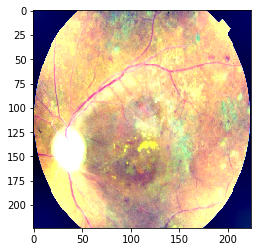

In [13]:
plt.imshow(x_train[5], interpolation='nearest')



# Model: DenseNet-121

In [14]:
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)

# Building the model

In [15]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.00005),
    metrics=['accuracy']
        )
    
    return model

In [16]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


# Training & Evaluation

In [17]:
#appa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    
)

Epoch 1/15
98/97 [==============================] - 84s 860ms/step - loss: 0.5264 - acc: 0.7406 - val_loss: 0.3831 - val_acc: 0.8349
Epoch 2/15
98/97 [==============================] - 45s 456ms/step - loss: 0.2869 - acc: 0.8822 - val_loss: 0.2316 - val_acc: 0.9116
Epoch 3/15
98/97 [==============================] - 46s 469ms/step - loss: 0.2448 - acc: 0.8987 - val_loss: 0.2157 - val_acc: 0.9062
Epoch 4/15
98/97 [==============================] - 46s 467ms/step - loss: 0.2190 - acc: 0.9091 - val_loss: 0.1740 - val_acc: 0.9269
Epoch 5/15
98/97 [==============================] - 45s 458ms/step - loss: 0.2059 - acc: 0.9149 - val_loss: 0.1737 - val_acc: 0.9255
Epoch 6/15
98/97 [==============================] - 46s 469ms/step - loss: 0.1834 - acc: 0.9237 - val_loss: 0.1702 - val_acc: 0.9269
Epoch 7/15
98/97 [==============================] - 46s 469ms/step - loss: 0.1752 - acc: 0.9286 - val_loss: 0.1521 - val_acc: 0.9371
Epoch 8/15
98/97 [==============================] - 46s 474ms/step - 

# Saving the model as CNN.model

In [19]:
model.save_weights("model.h5")
model.save('CNNmodel.h5')
print("model saved to disk")


model saved to disk


# Saving the model as joblib file

In [20]:
import joblib
joblib.dump(model,'JOBmodel.sav')


['JOBmodel.sav']

In [28]:
Jmodel = joblib.load('JOBmodel.sav')

# Saving the model as Pickle file

In [25]:
import pickle
filename = 'pickel_model.pkl'
loadedModel = pickle.dump(model,open(filename,'wb'))
print("model saved")


model saved


In [ ]:
from IPython.display import FileLink
FileLink(r'JOBmodel.sav')


# Plotting accuracy curves of both train & validation

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


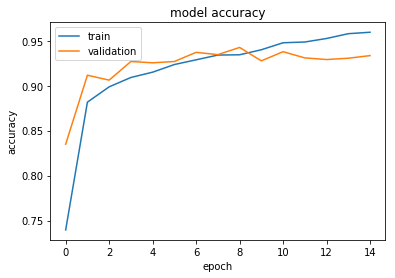

In [26]:
print(history.history.keys())
plt.figure(1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# Predicting a single image

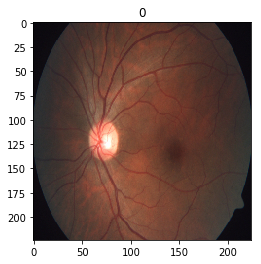

the diabetic retinopathy level of this eye is [0]


In [63]:
image_path=f'../input/aptos2019-blindness-detection/train_images/02358b47ea89.png'
img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
plt.imshow(img)
img = preprocess_image(image_path)
img = np.expand_dims(img, axis=0)
result=Jmodel.predict_classes(img)
plt.title(label = result[0])
plt.show()
print("the diabetic retinopathy level of this eye is {}".format(result))

In [57]:
sample_test_images = []
im_names = []
for i in range(0,20):
    img_path = train_df.loc[i,'id_code']
    im_names.append(img_path)
    img = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{img_path}.png')
    sample_test_images.append(img)

print(len(sample_test_images),"images are stored in a list")
    
    

20 images are stored in a list


In [61]:
print(im_names)

['000c1434d8d7', '001639a390f0', '0024cdab0c1e', '002c21358ce6', '005b95c28852', '0083ee8054ee', '0097f532ac9f', '00a8624548a9', '00b74780d31d', '00cb6555d108', '00cc2b75cddd', '00e4ddff966a', '00f6c1be5a33', '0104b032c141', '0124dffecf29', '0125fbd2e791', '012a242ac6ff', '014508ccb9cb', '0151781fe50b', '0161338f53cc']


# Predicting multiple images:

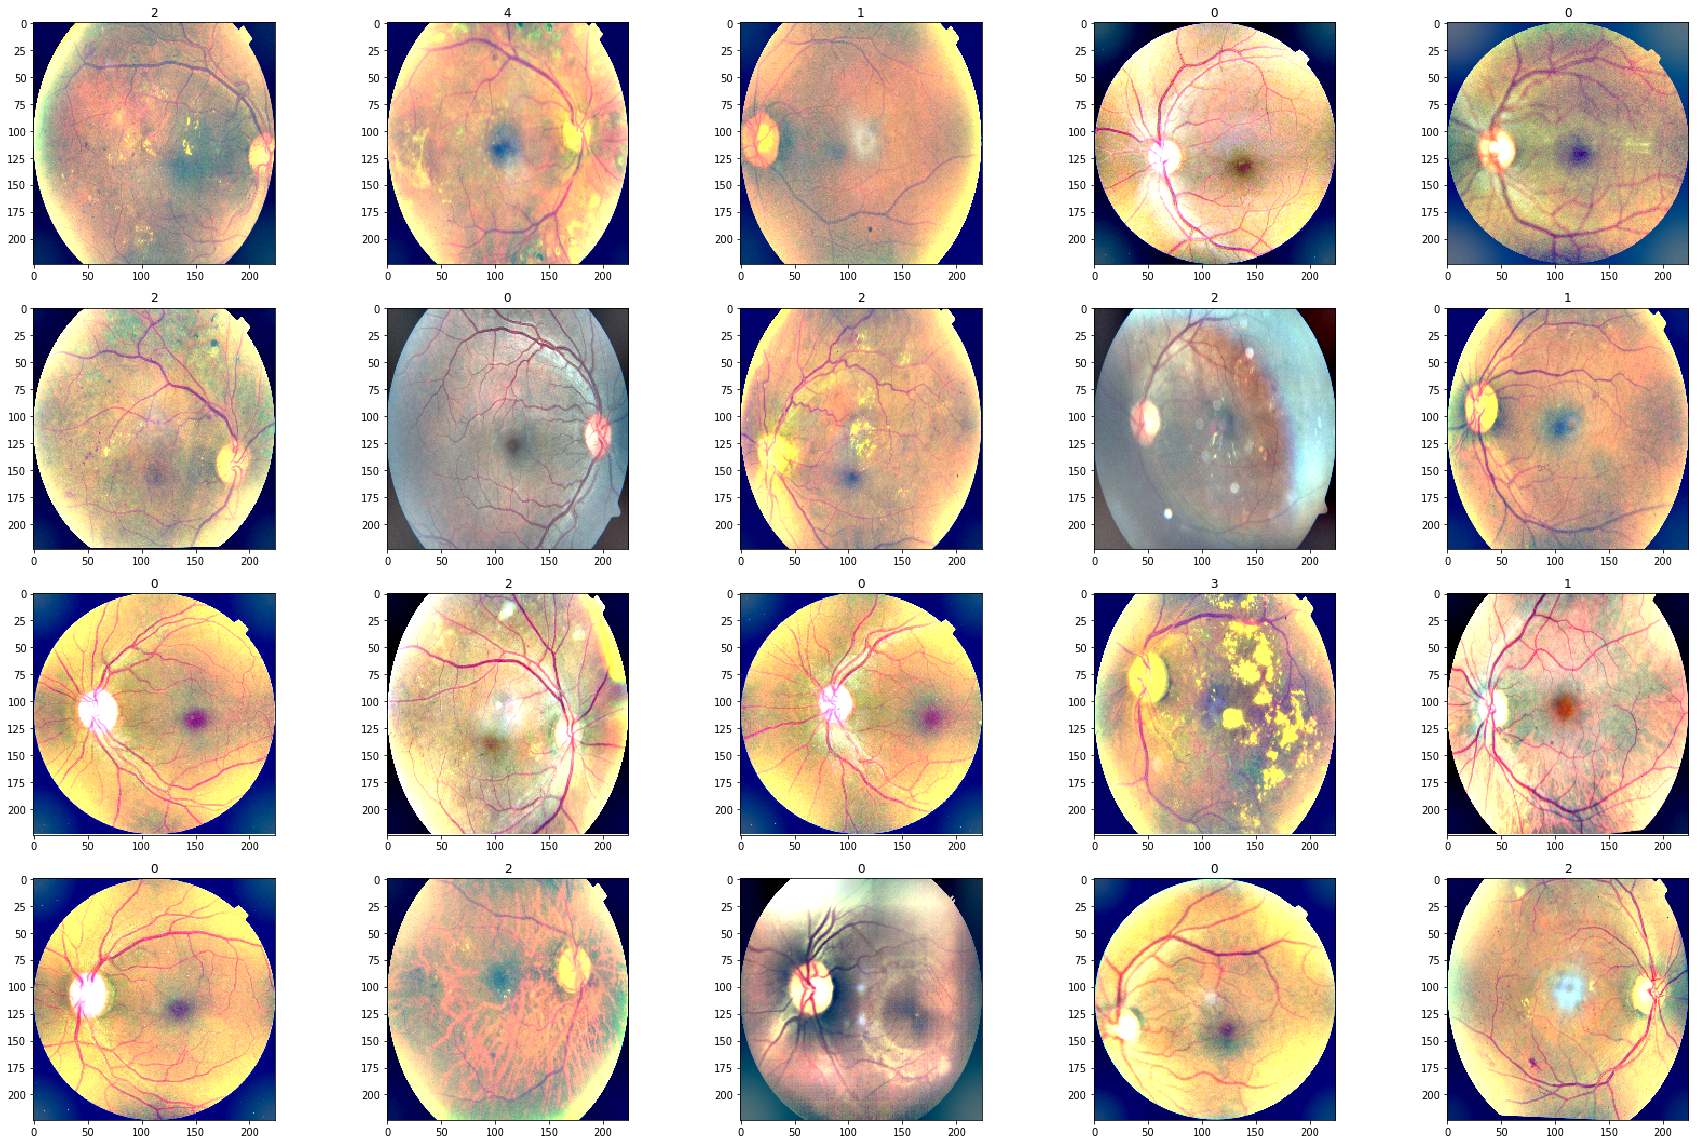

In [62]:
def predict_multiple(li, columns=5, rows=4):
    fig=plt.figure(figsize=(5*columns, 4*rows))
    for i in range(columns*rows):
        im = li[i]
        img = np.expand_dims(im, axis=0)
        result=Jmodel.predict_classes(img)
        fig.add_subplot(rows, columns, i+1)
        plt.title(result[0])
        plt.imshow(im, interpolation='nearest')
        
    plt.tight_layout()
    
predict_multiple(sample_test_images)    